# Предсказание цены на б/у автомобиль в Германии, анализ рынка и проверка статической гипотезы

Целью является предсказание цены по следующим параметрам: год регистрации, кробка передач, мощность двигателя, бренд, модель, пробег, "не бит, не крашен", вид топлива

импорт библиотек и загрузка датасета

In [46]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import pearsonr
from scipy.stats import spearmanr
df = pd.read_csv("autos.csv")
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TЬRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


копирование датасета только с нужными колонками

In [2]:
df1 = df[['yearOfRegistration', 'gearbox', 'powerPS', 'brand', 'model', 'kilometer', 'notRepairedDamage', 'fuelType', 'price']].copy()
df1.head()


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,NaN,benzin,480
1,2011,manuell,190,audi,NaN,125000,ja,diesel,18300
2,2004,automatik,163,jeep,grand,125000,NaN,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600


## Очистка данных

удаление строк, в которых неизвестна модель авто

In [3]:
df2 = df1[df1.model != "andere"]
df2.dropna(subset=['model'], how='all', inplace=True)
df2.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,NaN,benzin,480
2,2004,automatik,163,jeep,grand,125000,NaN,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650


удаление строк с нереальными годами и со слишком раритетным авто

In [4]:
df2['yearOfRegistration'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 2017, 1981, 2003, 1994, 1991, 1990,
       2006, 1999, 2012, 2010, 2013, 2000, 1992, 1996, 1985, 1989, 2015,
       1968, 1976, 1983, 1973, 1969, 1987, 1986, 1982, 1988, 1980, 1971,
       1984, 1970, 1979, 1974, 1965, 1978, 1972, 1966, 1977, 1961, 1963,
       1960, 5000, 1954, 1967, 1000, 1500, 2200, 1964, 3000, 2066, 9999,
       1975, 2019, 1959, 9000, 2900, 5900, 1945, 5911, 1400, 4000, 8000,
       1200, 8500, 1962, 3700, 1957, 1234, 1936, 1923, 2290, 1952, 6200,
       7000, 1930, 1938, 1956, 1950, 7500, 1800, 5555, 1300, 1111, 7100,
       2500, 8200, 1958, 1600], dtype=int64)

In [5]:
df2 = df2[df2['yearOfRegistration'].between(1950, 2020)]
df2

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,NaN,benzin,480
2,2004,automatik,163,jeep,grand,125000,NaN,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650
...,...,...,...,...,...,...,...,...,...
371522,2005,manuell,0,mitsubishi,colt,150000,ja,benzin,0
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200
371526,2002,manuell,100,volkswagen,golf,150000,NaN,diesel,3400


In [6]:
df2.yearOfRegistration.value_counts(dropna = False)

2000    20675
1999    20169
2005    20035
2006    18551
2001    18150
        ...  
1956        3
1954        3
1958        2
1957        1
1952        1
Name: yearOfRegistration, Length: 67, dtype: int64

удаление строк с неясной коробкой передач

In [7]:
df2.gearbox.value_counts(dropna = False)

manuell      242966
automatik     67129
NaN           14427
Name: gearbox, dtype: int64

In [8]:
df2.dropna(subset=['gearbox'], how='all', inplace=True)
df2

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,NaN,benzin,480
2,2004,automatik,163,jeep,grand,125000,NaN,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650
...,...,...,...,...,...,...,...,...,...
371522,2005,manuell,0,mitsubishi,colt,150000,ja,benzin,0
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200
371526,2002,manuell,100,volkswagen,golf,150000,NaN,diesel,3400


In [9]:
df2.kilometer.value_counts(dropna = False)

150000    202069
125000     32532
100000     13203
90000      10782
80000       9470
70000       8339
60000       7416
50000       6480
40000       5425
30000       5000
20000       4458
5000        3587
10000       1334
Name: kilometer, dtype: int64

удаление строк с неясным типом топлива

In [10]:
df2.fuelType.value_counts(dropna = False)

benzin     191171
diesel      95215
NaN         18710
lpg          4234
cng           501
hybrid        151
andere         86
elektro        27
Name: fuelType, dtype: int64

In [11]:
df2.dropna(subset=['fuelType'], how='all', inplace=True)
df2 = df2[df.fuelType != "andere"]
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,NaN,benzin,480
2,2004,automatik,163,jeep,grand,125000,NaN,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650
...,...,...,...,...,...,...,...,...,...
371522,2005,manuell,0,mitsubishi,colt,150000,ja,benzin,0
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200
371526,2002,manuell,100,volkswagen,golf,150000,NaN,diesel,3400


Будем рассматирвать машины с отсутствующими данными в колонке notRepairedDamage "не битыми и не крашенными"

In [12]:
df2['notRepairedDamage'] = df2['notRepairedDamage'].fillna("nein")
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,nein,benzin,480
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650
...,...,...,...,...,...,...,...,...,...
371522,2005,manuell,0,mitsubishi,colt,150000,ja,benzin,0
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200
371526,2002,manuell,100,volkswagen,golf,150000,nein,diesel,3400


удаление строк с неясной ценой. Пусть корректная цена лежит в промежутке от 100 евро до 200000 евро

In [13]:
df2.price.value_counts(dropna = False)

0        5459
1500     4030
500      3978
1200     3444
2500     3326
         ... 
20845       1
91900       1
20589       1
40899       1
8188        1
Name: price, Length: 5106, dtype: int64

In [14]:
df2 = df2[df2.price.between(100, 200000)]
df2.dropna(subset=['price'], how='all', inplace=True)
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,0,volkswagen,golf,150000,nein,benzin,480
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650
...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,0,opel,zafira,150000,nein,benzin,1150
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200
371526,2002,manuell,100,volkswagen,golf,150000,nein,diesel,3400


заполнение неясных или неправдоподобных данных по мощности модой для данной модели. Пусть интервал корректных мощностей лежит в промежутке от 30 л.с. до 500 л.с

In [15]:
df2.powerPS.value_counts(dropna = False)

75      19117
0       17318
60      12789
150     12746
140     12107
        ...  
1597        1
572         1
4507        1
1433        1
244         1
Name: powerPS, Length: 644, dtype: int64

In [16]:
dp = df2.groupby(['model'])['powerPS'].agg(lambda x:x.value_counts().index[0])
df2['powerPS'] = df2.apply(lambda x: x['powerPS'] if x['powerPS'] in range(30, 501) else dp.loc[x['model']], axis = 1)
df2 = df2[df2.powerPS != 0]
df2

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price
0,1993,manuell,75,volkswagen,golf,150000,nein,benzin,480
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650
...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,125,opel,zafira,150000,nein,benzin,1150
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200
371526,2002,manuell,100,volkswagen,golf,150000,nein,diesel,3400


In [17]:
df2[df2.model == 'zafira'].powerPS.value_counts()

125    727
101    409
150    349
120    239
140    184
116    147
147    121
105     61
97      44
110     43
100     35
94      32
165     31
115     31
200     22
192     21
82      19
241     11
102      8
74       5
122      5
145      5
92       4
130      4
103      3
90       3
118      3
81       3
75       3
126      3
143      3
128      3
149      3
124      2
108      2
80       2
146      2
131      2
96       2
85       2
112      1
104      1
88       1
154      1
132      1
136      1
144      1
239      1
156      1
160      1
170      1
300      1
107      1
117      1
119      1
129      1
141      1
155      1
193      1
62       1
Name: powerPS, dtype: int64

проверка наличия всех брендов

In [18]:
df2.brand.value_counts(dropna = False)

volkswagen       65081
bmw              34405
opel             31237
mercedes_benz    27943
audi             26943
ford             19817
renault          13625
peugeot           8060
fiat              6185
seat              5885
skoda             4878
mazda             3880
smart             3851
nissan            3559
toyota            3365
mini              3069
citroen           2769
volvo             2383
hyundai           2080
honda             2043
mitsubishi        1822
kia               1759
porsche           1600
alfa_romeo        1461
suzuki            1025
chrysler           846
dacia              788
land_rover         689
chevrolet          639
subaru             572
jeep               548
daihatsu           528
daewoo             342
lancia             289
jaguar             268
trabant            193
saab               127
lada               118
rover               12
Name: brand, dtype: int64

In [19]:
df3 = df2.copy()

In [20]:
df3['age'] = 2020 - df['yearOfRegistration']
df3

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price,age
0,1993,manuell,75,volkswagen,golf,150000,nein,benzin,480,27
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800,16
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500,19
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600,12
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650,25
...,...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,125,opel,zafira,150000,nein,benzin,1150,20
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199,20
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200,24
371526,2002,manuell,100,volkswagen,golf,150000,nein,diesel,3400,18


добавление свойства, которое показывает соотношение цены к среднему годовому пробегу. Этот показатель позволит объективнее посмотреть на цену и отбросить строки с неправдоподобными ценами

In [21]:
df3['priceInd'] = df3.price/(df3.kilometer/df3.age)
df3

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price,age,priceInd
0,1993,manuell,75,volkswagen,golf,150000,nein,benzin,480,27,0.086400
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800,16,1.254400
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500,19,0.190000
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600,12,0.480000
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650,25,0.108333
...,...,...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,125,opel,zafira,150000,nein,benzin,1150,20,0.153333
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199,20,0.191840
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200,24,1.472000
371526,2002,manuell,100,volkswagen,golf,150000,nein,diesel,3400,18,0.408000


In [22]:
df3.priceInd.describe()

count    284684.000000
mean          1.128055
std           8.015089
min           0.002000
25%           0.190000
50%           0.420000
75%           0.932900
max        1813.000000
Name: priceInd, dtype: float64

оставим только те машины, чьи показатели цены от годового пробега лежат в промежутке ± 1σ

In [23]:
df4 = df3[df3.priceInd.between(np.mean(df3.priceInd) - np.std(df3.priceInd), np.mean(df3.priceInd) + np.std(df3.priceInd))]
df4.index.name = 'id'
df4

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price,age,priceInd
id,,,,,,,,,,,
0,1993,manuell,75,volkswagen,golf,150000,nein,benzin,480,27,0.086400
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800,16,1.254400
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500,19,0.190000
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600,12,0.480000
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650,25,0.108333
...,...,...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,125,opel,zafira,150000,nein,benzin,1150,20,0.153333
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199,20,0.191840
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200,24,1.472000


In [24]:
df4.priceInd.describe()

count    281022.000000
mean          0.795877
std           1.126403
min           0.002000
25%           0.187500
50%           0.411667
75%           0.899850
max           9.137500
Name: priceInd, dtype: float64

In [25]:
df4.corr()['price'].sort_values()

age                  -0.518293
kilometer            -0.434066
yearOfRegistration    0.518293
powerPS               0.582728
priceInd              0.772108
price                 1.000000
Name: price, dtype: float64

получим dummies для модели и типа топлива. Брэнд не будет участвовать в качестве свойства, так как модель уже подразумевает разделение марок авто. Для коробки передач и "битости-крашенности" создадим колонку из 1 и 0 при помощи функции

In [26]:
fd = pd.get_dummies(df4.fuelType)
fd

,benzin,cng,diesel,elektro,hybrid,lpg
id,,,,,,
0,1,0,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,0,0,1,0,0,0
5,1,0,0,0,0,0
...,...,...,...,...,...,...
371521,1,0,0,0,0,0
371524,1,0,0,0,0,0
371525,0,0,1,0,0,0


In [27]:
md = pd.get_dummies(df4.model)
md

,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,...,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
371524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def gbCode(x):
    t = 1
    if x == 'manuell':
        t = 0    
    return t
gbc = df4.gearbox.apply(gbCode)
gbc

id
0         0
2         1
3         0
4         0
5         0
         ..
371521    0
371524    1
371525    0
371526    0
371527    0
Name: gearbox, Length: 281022, dtype: int64

In [29]:
def nrdCode(x):
    t = 1
    if x == 'nein':
        t = 0    
    return t
nrdc = df4.notRepairedDamage.apply(nrdCode)
nrdc

id
0         0
2         0
3         0
4         0
5         1
         ..
371521    0
371524    0
371525    0
371526    0
371527    0
Name: notRepairedDamage, Length: 281022, dtype: int64

In [30]:
X2 = pd.concat([nrdc, gbc], axis = 1)
X2.columns = ["nrd", "gb"]
X2

,nrd,gb
id,,
0,0,0
2,0,1
3,0,0
4,0,0
5,1,0
...,...,...
371521,0,0
371524,0,1
371525,0,0


In [31]:
X1 = pd.concat([md.drop('100', axis = 1), fd.drop('lpg', axis = 1)], axis = 1)
X1

,145,147,156,159,1_reihe,1er,200,2_reihe,300c,3_reihe,...,yaris,yeti,ypsilon,z_reihe,zafira,benzin,cng,diesel,elektro,hybrid
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
371524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
371525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
X0 = pd.concat([df4[['powerPS', 'kilometer', 'age']], X1], axis = 1)
X0

,powerPS,kilometer,age,145,147,156,159,1_reihe,1er,200,...,yaris,yeti,ypsilon,z_reihe,zafira,benzin,cng,diesel,elektro,hybrid
id,,,,,,,,,,,,,,,,,,,,,
0,75,150000,27,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,163,125000,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,75,150000,19,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,69,90000,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,102,150000,25,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371521,125,150000,20,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
371524,101,125000,20,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
371525,102,150000,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
X = pd.concat([X0, X2], axis = 1)
X

,powerPS,kilometer,age,145,147,156,159,1_reihe,1er,200,...,ypsilon,z_reihe,zafira,benzin,cng,diesel,elektro,hybrid,nrd,gb
id,,,,,,,,,,,,,,,,,,,,,
0,75,150000,27,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,163,125000,16,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,75,150000,19,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,69,90000,12,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,102,150000,25,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371521,125,150000,20,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
371524,101,125000,20,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
371525,102,150000,24,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [33]:
y = df4.price
y

id
0           480
2          9800
3          1500
4          3600
5           650
          ...  
371521     1150
371524     1199
371525     9200
371526     3400
371527    28990
Name: price, Length: 281022, dtype: int64

In [47]:
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 200],
            'max_depth': [6, 10],
        }
    },
    'xgboost' : {
        'model': xgb.XGBRegressor(),
        'params': {
            'n_estimators': [50, 200],
            'learning_rate': [0.01, 0.1]
        }
    }
}

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [54]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=[(slice(None), slice(None))])
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
mod_scr = pd.DataFrame(scores,columns=['model','best_score','best_params'])
mod_scr

,model,best_score,best_params
0,random_forest,0.870619,"{'max_depth': 10, 'n_estimators': 200}"
1,xgboost,0.900127,"{'learning_rate': 0.1, 'n_estimators': 200}"


Для обучения модели будет использоваться xgboostRegressor. При помощи RandomizedSearchCV найдём лучшие параметры

In [48]:
xgb = xgb.XGBRegressor()
param_space = {
        "gamma": [1, 10, 50],
        "max_depth": [10, 5],
        "learning_rate": [0.1, 0.05],
        "n_estimators": [100, 500]
}
xgb_optim = RandomizedSearchCV(xgb, param_space, n_iter=8, cv=[(slice(None), slice(None))], random_state=42)

xgb_optim.fit(X_train, y_train)

    

RandomizedSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_

In [49]:
xgb_optim.best_params_

{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1}

In [50]:
xgb_model = xgb_optim.best_estimator_
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

убедимся, что модель не переобучена или недообучена

In [51]:
score_train = cross_val_score(xgb_model, X_train, y_train, cv = 4)

In [52]:
score_test = cross_val_score(xgb_model, X_test, y_test, cv = 4)

In [53]:
score_train

array([0.90520696, 0.91051754, 0.911544  , 0.90179266])

In [54]:
score_test

array([0.89432913, 0.88609727, 0.89476518, 0.88688794])

In [55]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
def price_pred(pwr, km, age, mdl, fuel, nrd, grb):
    mdl_index = np.where(X.columns == mdl)[0][0]
    fuel_index = np.where(X.columns == fuel)[0][0]
    
        
    x = np.zeros(len(X.columns))
    x[0] = pwr
    x[1] = km
    x[2] = age
    x[-1] = grb
    x[-2] = nrd
    if mdl_index >= 0:
        x[mdl_index] = 1
    if fuel_index >= 0:
        x[fuel_index] = 1 
    df = pd.DataFrame(x)
    return print(xgb_model.predict(df.set_index(X.columns).T))

Предсказание цены на VW Golf с двигателем мощностью в 140л.с., пробегом 125000 км, возрастом 8 лет, бензиновым двс, не битый, не крашенный и с АКПП

In [57]:
price_pred(140, 125000, 8, 'golf', 'benzin', 0, 1)

[12709.26]


вывод схожего запроса, чтобы убедиться, что цена лежит в разумном пределе

In [58]:
df4[(df4.model == 'golf') & (df4.gearbox == 'automatik') & (df4.age.between(6, 10)) & (df4.fuelType == 'benzin') & (df4.notRepairedDamage == 'nein') & (df4.kilometer.between(100000, 150000)) & (df4.powerPS.between(120, 180))]

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price,age,priceInd
id,,,,,,,,,,,
1090,2011,automatik,160,volkswagen,golf,125000,nein,benzin,12950,9,0.932400
22141,2010,automatik,170,volkswagen,golf,125000,nein,benzin,7500,10,0.600000
24336,2011,automatik,160,volkswagen,golf,100000,nein,benzin,12990,9,1.169100
50274,2010,automatik,122,volkswagen,golf,150000,nein,benzin,8999,10,0.599933
100065,2010,automatik,122,volkswagen,golf,125000,nein,benzin,12900,10,1.032000
138501,2010,automatik,122,volkswagen,golf,100000,nein,benzin,9990,10,0.999000
153326,2012,automatik,160,volkswagen,golf,150000,nein,benzin,10300,8,0.549333
174228,2011,automatik,122,volkswagen,golf,100000,nein,benzin,14500,9,1.305000
205583,2010,automatik,122,volkswagen,golf,125000,nein,benzin,10950,10,0.876000


определение ценого индекса для каждого бренда

In [59]:
df5 = pd.DataFrame(df4.groupby('brand')['priceInd'].agg('mean'))
df5

,priceInd
brand,
alfa_romeo,0.499155
audi,1.069701
bmw,1.014405
chevrolet,0.875522
chrysler,0.626180
citroen,0.599270
dacia,1.000126
daewoo,0.190007
daihatsu,0.326936


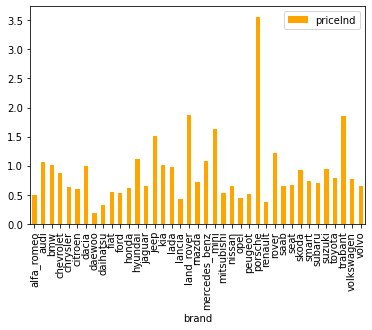

In [60]:
df5.plot.bar(y='priceInd', rot=90, color = 'orange')

из графика следует, что самые дорогие машины - Porsche, Land Rover и Trabant(по всей видимости, эти машины являются коллекционными) самые бюджетные - Daewoo, Daihatsu и Renault

In [61]:
df6 = pd.DataFrame(df4.groupby('brand')['price'].agg('count')).sort_values('price', ascending = True)
df6['share'] = df6.price*100/df6.price.sum()
df6

,price,share
brand,,
rover,12,0.004270
lada,116,0.041278
saab,127,0.045192
trabant,174,0.061917
jaguar,267,0.095010
lancia,287,0.102127
daewoo,342,0.121699
daihatsu,526,0.187174
jeep,530,0.188597


In [62]:
df6['brand_sh'] = df6.share.apply(lambda x: x if x > 1.5 else df6[df6['share'] < 1.5].share.sum())
df7 = pd.DataFrame(df6.brand_sh.round(2).drop_duplicates())
df7.rename(index={'rover':'other'},inplace=True)
df7

,brand_sh
brand,
other,14.12
skoda,1.71
seat,2.08
fiat,2.18
peugeot,2.86
renault,4.84
ford,6.98
audi,9.43
mercedes_benz,9.78


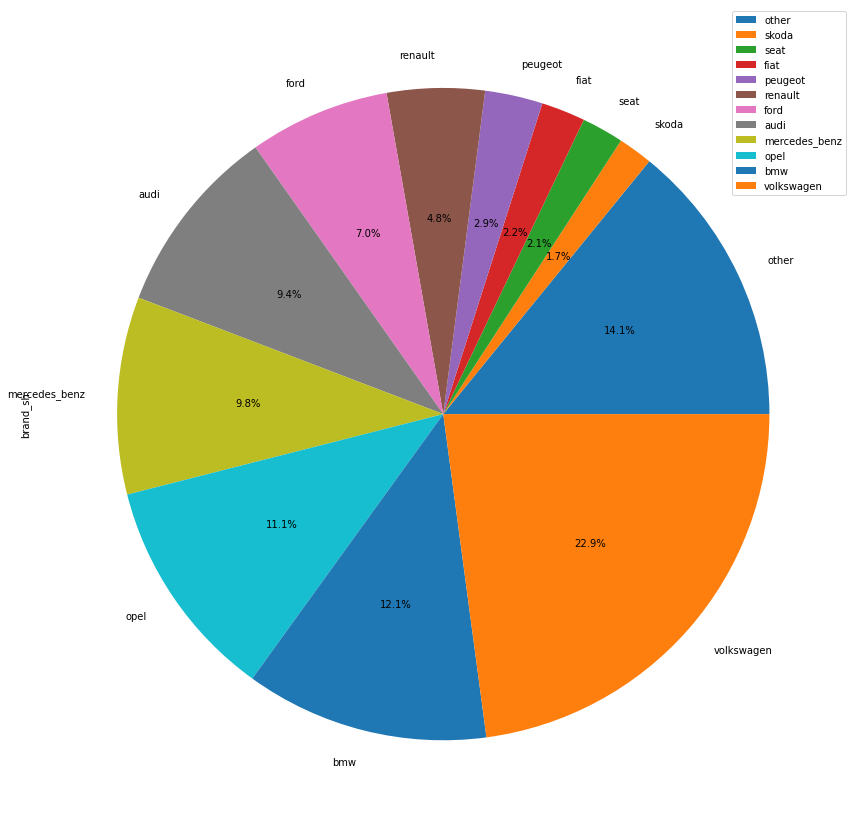

In [63]:
df7.plot.pie(y='brand_sh', figsize=(15, 15),  autopct='%1.1f%%')

на этой диаграмме видно, что Volkswagen оправдано носит своё имя народного автомобиля, обходя ближайшего конкурента почти в 2 раза

# Проверка статистических гипотез

проверим есть ли корреляция между распределеием цен на автомобили и распределением зарплат в Германии. Данные за 2016 год взяты отсюда https://www.iwd.de/artikel/mittelschicht-oder-reich-441648/ 

In [64]:
inc = pd.read_csv("income.csv")
inc.head(20)

,range,Gesamtbevölkerung
0,weniger als 400 Euro,0.9
1,401 bis 800,5.9
2,801 bis 1200,12.9
3,1201 bis 1600,18.0
4,1601 bis 2000,17.8
5,2001 bis 2400,14.7
6,2401 bis 2800,10.0
7,2801 bis 3200,7.1
8,3201 bis 3600,4.1
9,3601 bis 4000,2.5


где range диапазон зарплат и Gesamtbevölkerung процент населения 

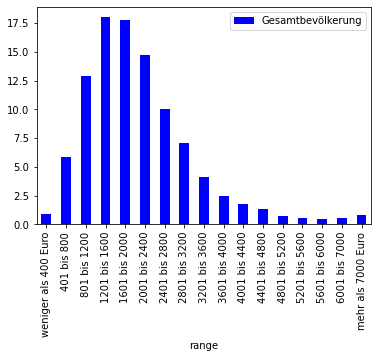

In [65]:
inc.plot.bar(x= 'range', y='Gesamtbevölkerung', rot=90, color = 'blue')

In [66]:
df4

,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price,age,priceInd
id,,,,,,,,,,,
0,1993,manuell,75,volkswagen,golf,150000,nein,benzin,480,27,0.086400
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800,16,1.254400
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500,19,0.190000
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600,12,0.480000
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650,25,0.108333
...,...,...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,125,opel,zafira,150000,nein,benzin,1150,20,0.153333
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199,20,0.191840
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200,24,1.472000


Разобьём автомобили на 17 сегментов (так же как и в таблице с доходами). Шагом будет медиана цены

In [67]:
step = df4.price.median() 
df4['segment'] = (df4.price//step).apply(lambda x: 16 if x>15 else x )
df4

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,yearOfRegistration,gearbox,powerPS,brand,model,kilometer,notRepairedDamage,fuelType,price,age,priceInd,segment
id,,,,,,,,,,,,
0,1993,manuell,75,volkswagen,golf,150000,nein,benzin,480,27,0.086400,0.0
2,2004,automatik,163,jeep,grand,125000,nein,diesel,9800,16,1.254400,2.0
3,2001,manuell,75,volkswagen,golf,150000,nein,benzin,1500,19,0.190000,0.0
4,2008,manuell,69,skoda,fabia,90000,nein,diesel,3600,12,0.480000,1.0
5,1995,manuell,102,bmw,3er,150000,ja,benzin,650,25,0.108333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
371521,2000,manuell,125,opel,zafira,150000,nein,benzin,1150,20,0.153333,0.0
371524,2000,automatik,101,smart,fortwo,125000,nein,benzin,1199,20,0.191840,0.0
371525,1996,manuell,102,volkswagen,transporter,150000,nein,diesel,9200,24,1.472000,2.0


In [68]:
sales = df4.groupby('segment')['price'].agg('sum')
sales

segment
0.0     215565595
1.0     293808258
2.0     279058245
3.0     209359025
4.0     189477592
5.0     126159727
6.0      96094784
7.0      71653939
8.0      49311780
9.0      27499400
10.0     22570972
11.0     13523439
12.0      9107110
13.0      6235613
14.0      4534974
15.0      2887483
16.0      5789032
Name: price, dtype: int64

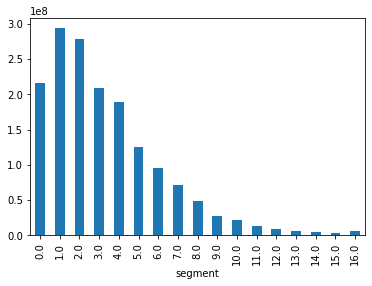

In [69]:
sales.plot.bar()

Изобразим полученные результаты на одном графике

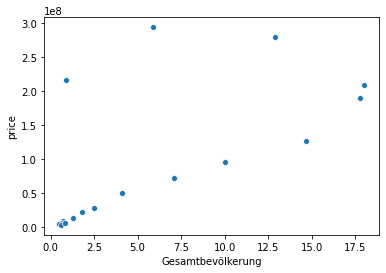

In [70]:
sns.scatterplot(x = inc.Gesamtbevölkerung, y = sales)

Если игнорировать 3 значения в левом верхнем углу, то проглядываетя линейная зависимость между данными.
Проверим гипотезу, найдя коэффициент корреляции Пирсона

In [71]:
corr, p = pearsonr(inc.Gesamtbevölkerung, sales)
print(p)
print(corr)


0.005134923561301861
0.6454720212428651


р значение не превышает уровень значимости (0,05), а следовательно у нас есть основания отвергнуть нулевую гипотезу, утверждающую, что связи нет. Но так как всё таки имеются выбросы, нужно использовать коэффициент корреляции Спирмена, но для этого вначале приведём данные к рангам

In [72]:
inc_Rank = inc.Gesamtbevölkerung.rank()
inc_Rank

0      6.0
1     11.0
2     14.0
3     17.0
4     16.0
5     15.0
6     13.0
7     12.0
8     10.0
9      9.0
10     8.0
11     7.0
12     4.0
13     2.5
14     1.0
15     2.5
16     5.0
Name: Gesamtbevölkerung, dtype: float64

In [73]:
sales_Rank = sales.rank()
sales_Rank

segment
0.0     15.0
1.0     17.0
2.0     16.0
3.0     14.0
4.0     13.0
5.0     12.0
6.0     11.0
7.0     10.0
8.0      9.0
9.0      8.0
10.0     7.0
11.0     6.0
12.0     5.0
13.0     4.0
14.0     2.0
15.0     1.0
16.0     3.0
Name: price, dtype: float64

In [74]:
corr, p = spearmanr(inc_Rank, sales_Rank)
print(p)
print(corr)


0.00015653318745556983
0.7909259610463494


р значение получилось ещё меньше, чего, собственно, и следовало ожидать. Коэффициент корреляции равный 0,791 показывет, что между данными существует достаточно явная связь